# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** K

**Names:**

* Mathieu Sauser
* Jérémy Chaverot
* Heikel Jebali
* Luca Mouchel
---

#### Instructions

*This is a template for part 2 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.2 Network sampling

#### Exercise 2.7: Random walk on the Facebook network

In [1]:
import requests
import random
import numpy as np
#test

In [2]:
#test

Please note we originally started by setting $u=v$ at random but we then decided to sample $v$ by making it a user that was not seen previously so that each node that we visit is unique. 

In [3]:
URL_TEMPLATE = 'http://iccluster050.iccluster.epfl.ch:5050/v1.0/facebook?user={user_id}'

"""
    This function returns the data of a user with the given user_id in JSON format.
"""
def get_data(user_id):
    return requests.get(URL_TEMPLATE.format(user_id=user_id)).json()

"""
    This function will return a random friend if it has not been seen before.
    If all friends have already been seen, then we pick a friend at random and repeat the process to find a friend that has not been seen.
    This allows us to avoid resampling from already seen users.
"""
def sample_user(querying_user_friends, seen_users):
    potential_users = [friend for friend in querying_user_friends if friend not in seen_users]
    if len(potential_users) == 0:        
        return sample_user(querying_user_friends= get_data(random.choice(querying_user_friends))['friends'], seen_users=seen_users)
    else:
        return random.choice(potential_users)

"""
    This function performs a random walk on the Facebook graph, starting from the Source s and visits N nodes.
    we retrieve data from each node and store the age of each node in the ages list which 
    we use to compute the average age.
"""
def random_walk(s, N, log_progess=False):
    #attributes is a list of tuples (user_id, age, number_of_friends)
    attributes = []
    source = get_data(s)
    attributes.append((s, source['age'], len(source['friends'])))

    seen = set()
    u = s
    i = 0
    while i < N:
        if log_progess:
            if i % 100 == 0 and i != 0:
                ages = np.array(attributes)[:,1].astype(np.int64)
                print(f'{i} iterations done, current age average: {round(np.mean(ages), 2)}')
        data = get_data(u)
        age = data['age']
        neighbors = data['friends']
        u = sample_user(querying_user_friends=neighbors,  seen_users=seen)
        seen.add(u)
        attributes.append((u, age, len(neighbors)))
        i = i+1
    return attributes
#because we have tuples of the form (user_id, age, number_of_friends), to collect the list of ages, we apply numpy 
#slicing using [:, 1] which returns every element of index 1 in the tuple, which is the age.
ages = np.array(random_walk(s="a5771bce93e200c36f7cd9dfd0e5deaa", N=1000, log_progess=True))[:, 1].astype(np.int64)
print(f"At 1000 iterations, we estimate that the average age is: {round(np.mean(ages), 3)}")


100 iterations done, current age average: 21.98
200 iterations done, current age average: 24.32
300 iterations done, current age average: 24.68
400 iterations done, current age average: 25.02
500 iterations done, current age average: 25.41
600 iterations done, current age average: 24.71
700 iterations done, current age average: 25.12
800 iterations done, current age average: 25.26
900 iterations done, current age average: 24.99
At 1000 iterations, we estimate that the average age is: 25.331


Our estimation of the average age of a Facebook user is $25.3$ years. To get this estimation, we visited $1000$ users.

#### Exercise 2.8

$1.$ Our estimation is pretty far from the true average age, by nearly 20 years.

$2.$ It seems people tend to be friends with users the same age as them. When doing a random walk, we sample users who tend to have the same age, so calculating the average does not include users from a different age group.

$3.$ As seen in class, we will use an unbiased estimator. Because we don't know the total number of edges and the total number of vertices, the estimator we use is the following:

$$\hat{F} = \frac{\sum_t f(X_t)/d_{X_t}}{\sum_t 1/d_{X_t}}$$ 

In our case: 
- $f(X_t)$ represents the age
- $d_{X_t}$ is the degree of the node




In [4]:
ls = random_walk("a5771bce93e200c36f7cd9dfd0e5deaa", 1000, False)

Basically, each user we visit appears exactly once in the computations then we collect the ages and degrees, and compute the unbiased estimator which gives a result very close to the average age released by facebook. If we visit a larger number of nodes, we would surely get closer to the true average age.

In [5]:
def unbiased_estimator(ages, degrees):
    #return the value of the unbiased estimator
    return np.sum(ages / degrees) / np.sum(1/degrees)

In [6]:
ages = np.array(ls)[:, 1].astype(np.int64)
degrees = np.array(ls)[:, 2].astype(np.int64)
round(unbiased_estimator(ages=ages, degrees=degrees), 2)

45.23

We find an estimated average age of $45.2$ years which is really close to the one the study published.

Without using an unbiased estimator, one could try to have a naive approach and just visit each node only once and compute the mean but this still shows some bias as we can see that the age we find is far from the average age facebook released.

In [7]:
def inaccurate_estimation():
    ages = np.array([entry[1] for  entry in ls])
    return np.mean(ages)
round(inaccurate_estimation(), 2)

23.69

Plotting the evolution of the estimator

In [8]:
def estimator_evolution():
    for i in range(1, len(ls)):
        yield unbiased_estimator(ages[0:i], degrees[0:i])

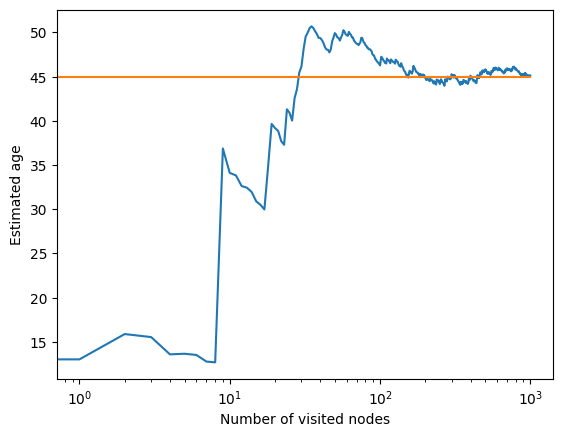

In [10]:
import matplotlib.pyplot as plt
plt.plot(list(estimator_evolution()))
plt.plot([45]*len(ls))
plt.xlabel('Number of visited nodes')
plt.ylabel('Estimated age')
plt.xscale('log')

We can see a large rise around 10 nodes visited and a slow convergence until when we visit around 1000 nodes.